This project develops a two-level machine learning trading strategy that simplifies signals into classification models - buy, neutral, sell. At both levels, classification models predict the direction of future returns. A rule-based system then integrates these predictions to make trading decisions — for example, only executing trades when both models expect positive returns that exceed certain thresholds. By blending models and incorporating confidence-based rules, the algorithm aims to balance signal strength with risk control for more reliable trading outcomes.

In [34]:
%pip install ta --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Finance
import yfinance as yf
import ta

# Data Preparation & Feature Engineering

Define hyperparameter list.

In [36]:
hyperparams = {}

Import SPY historical data as well as other valuable TICKERS such as VIX and TNX.

In [37]:
def get_price_data(ticker, start_date='1993-01-29', end_date=None):
    df = yf.download(ticker,start=start_date,end=end_date,auto_adjust=False,progress=False,multi_level_index=False)
    df = df.reset_index()
    df['Date'] = df['Date'].astype('datetime64[ns]')

    # Include VIX
    vix = yf.download('^VIX', start=start_date, end=end_date, auto_adjust=False, progress=False,multi_level_index=False)
    vix = vix.reset_index()[['Date', 'Adj Close']].rename(columns={'Adj Close': 'VIX'})
    vix['Date'] = pd.to_datetime(vix['Date'])

    df_merged = df.merge(vix, on='Date', how='left')

    # Include 10yr Treasury Yield
    tenyr = yf.download('^TNX', start=start_date, end=end_date,auto_adjust=False, progress=False,multi_level_index=False)
    tenyr = tenyr[['Adj Close']].rename(columns={'Adj Close': 'TNX'})

    df = df_merged.merge(tenyr[['TNX']], left_on='Date', right_index=True, how='left')

    return df

df = get_price_data('SPY')
df

,Date,Adj Close,Close,High,Low,Open,Volume,VIX,TNX
0,1993-01-29,24.452513,43.937500,43.968750,43.750000,43.968750,1003200,12.420000,6.390
1,1993-02-01,24.626434,44.250000,44.250000,43.968750,43.968750,480500,12.330000,6.380
2,1993-02-02,24.678616,44.343750,44.375000,44.125000,44.218750,201300,12.250000,6.460
3,1993-02-03,24.939482,44.812500,44.843750,44.375000,44.406250,529400,12.120000,6.450
4,1993-02-04,25.043825,45.000000,45.093750,44.468750,44.968750,531500,12.290000,6.390
...,...,...,...,...,...,...,...,...,...
8106,2025-04-11,533.940002,533.940002,536.429993,520.070007,523.010010,97866300,37.560001,4.493
8107,2025-04-14,539.119995,539.119995,544.280029,533.859985,544.049988,68034000,30.889999,4.364
8108,2025-04-15,537.609985,537.609985,543.229980,536.809998,539.669983,56892900,30.120001,4.323
8109,2025-04-16,525.659973,525.659973,537.890015,520.289978,531.679993,83484800,32.639999,4.279


Engineer features using **ta** library for ML.

In [38]:
hyperparams.update({'rsi_window':14,'stoch_window':14,'sma_windows':(20, 50),'ema_windows':(20,),'bb_window':20,'std_window':20,'atr_window':14})
hyperparams

{'rsi_window': 14,
 'stoch_window': 14,
 'sma_windows': (20, 50),
 'ema_windows': (20,),
 'bb_window': 20,
 'std_window': 20,
 'atr_window': 14}

In [39]:
def features_engineer(df, rsi_window=hyperparams['rsi_window'],stoch_window=hyperparams['stoch_window'],
                      sma_windows=hyperparams['sma_windows'],ema_windows=hyperparams['ema_windows'],bb_window=hyperparams['bb_window'],
                      std_window=hyperparams['std_window'],atr_window=hyperparams['atr_window']):
    df = df.copy()

    # Shift VIX to avoid data leakage
    df['Lag1_VIX'] = df['VIX'].shift(1)
    df['Lag1_TNX'] = df['TNX'].shift(1)
    df = df.drop(columns=['VIX','TNX'])


    # Momentum Indicators
    df['RSI'] = ta.momentum.RSIIndicator(df['Adj Close'], window=rsi_window).rsi()
    macd = ta.trend.MACD(df['Adj Close'])  # MACD uses default fast=12, slow=26
    df['MACD'] = macd.macd()
    df['Stoch_Osc'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=stoch_window).stoch()

    # Trend Indicators
    for window in sma_windows:
        df[f'SMA{window}'] = ta.trend.SMAIndicator(df['Adj Close'], window=window).sma_indicator()
    for window in ema_windows:
        df[f'EMA{window}'] = ta.trend.EMAIndicator(df['Adj Close'], window=window).ema_indicator()

    # Volatility Indicators
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=atr_window).average_true_range()
    bb = ta.volatility.BollingerBands(df['Adj Close'], window=bb_window)
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()
    df[f'Rolling_Std_{std_window}'] = df['Adj Close'].rolling(window=std_window).std()

    # Volume Indicators
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Adj Close'], df['Volume']).on_balance_volume()
    df['Volume_Change'] = df['Volume'].pct_change()

    # Return Features
    df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

    # Extra Features

    df['Daily_Range'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])  # size of candlestick body
    df['Gap'] = df['Open'] - df['Close'].shift(1)

    return df

Drop NA values associated with methods requiring windows

In [40]:
df_features = features_engineer(df, rsi_window=14,stoch_window=14,sma_windows=(20, 50),ema_windows=(20,),bb_window=20,std_window=20,atr_window=14).dropna().reset_index(drop=True)
df_features

,Date,Adj Close,Close,High,Low,Open,Volume,Lag1_VIX,Lag1_TNX,RSI,...,ATR,BB_High,BB_Low,Rolling_Std_20,OBV,Volume_Change,Log_Return,Daily_Range,Body,Gap
0,1993-04-12,25.109694,44.906250,44.937500,44.656250,44.718750,348500,12.830000,5.970,53.661763,...,0.400214,25.459214,24.663672,0.204052,2370900,0.927544,0.014016,0.281250,0.187500,0.437500
1,1993-04-13,25.162100,45.000000,45.156250,44.843750,44.875000,146100,11.930000,5.920,55.000254,...,0.393949,25.452781,24.664540,0.202180,2517000,-0.580775,0.002085,0.312500,0.125000,-0.031250
2,1993-04-14,25.127171,44.937500,45.062500,44.906250,45.031250,119600,11.700000,5.930,53.883085,...,0.376970,25.442881,24.665382,0.199424,2397400,-0.181383,-0.001389,0.156250,0.093750,0.031250
3,1993-04-15,25.127171,44.937500,45.031250,44.750000,44.906250,148600,11.760000,5.900,53.883085,...,0.370133,25.447480,24.667379,0.200092,2546000,0.242475,0.000000,0.281250,0.031250,-0.031250
4,1993-04-16,25.127171,44.937500,45.031250,44.875000,44.968750,47900,10.960000,5.880,53.883085,...,0.354856,25.437465,24.668336,0.197277,2593900,-0.677658,0.000000,0.156250,0.031250,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8036,2025-04-11,533.940002,533.940002,536.429993,520.070007,523.010010,97866300,40.720001,4.394,44.417779,...,20.058730,597.210202,502.161759,24.379411,17970156700,-0.397120,0.017686,16.359985,10.929993,-1.570007
8037,2025-04-14,539.119995,539.119995,544.280029,533.859985,544.049988,68034000,37.560001,4.493,46.230718,...,19.370253,595.531512,501.207545,24.193587,18038190700,-0.304827,0.009655,10.420044,4.929993,10.109985
8038,2025-04-15,537.609985,537.609985,543.229980,536.809998,539.669983,56892900,30.889999,4.364,45.762132,...,18.445233,594.385456,500.180858,24.162970,17981297800,-0.163758,-0.002805,6.419983,2.059998,0.549988
8039,2025-04-16,525.659973,525.659973,537.890015,520.289978,531.679993,83484800,30.120001,4.323,42.123365,...,18.384862,592.522536,498.066868,24.227368,17897813000,0.467403,-0.022479,17.600037,6.020020,-5.929993


Now lets get the target/label for our supervised ML.

In [41]:
hyperparams['buy_threshold'] = 0.005
hyperparams['sell_threshold'] = 0.005
print(f'Buy Threshold = {int(hyperparams['buy_threshold']*10000)} bps\nSell Threshold = {int(hyperparams['sell_threshold']*10000)} bps')

def create_trading_target(log_returns, buy_threshold=hyperparams['buy_threshold'], sell_threshold=hyperparams['sell_threshold']):
    return log_returns.apply(lambda x: 1 if x > buy_threshold else (-1 if x < -sell_threshold else 0)).values

df_features['Target'] = create_trading_target(df_features['Log_Return'].shift(-1)) # Shift to give next day returns associated with previous day close.

Buy Threshold = 50 bps
Sell Threshold = 50 bps


In [42]:
def tag_time_splits(df, val_start, test_start):
    df = df.copy()
    df['set'] = 'train'
    df.loc[df['Date'] >= val_start, 'set'] = 'validate'
    df.loc[df['Date'] >= test_start, 'set'] = 'test'
    return df

def get_X_y(df, set_name):
    subset = df[df['set'] == set_name]
    X = subset.drop(columns=['Date', 'Target', 'set'])
    y = subset['Target']
    return X, y

split_date = '2025-03-20'
tr_val_split_date = '2019-01-01'

df_full = tag_time_splits(df_features, tr_val_split_date, split_date).reset_index(drop=True)
df_full

X_train, y_train = get_X_y(df_full, 'train')
X_val, y_val     = get_X_y(df_full, 'validate')
X_test, y_test   = get_X_y(df_full, 'test')


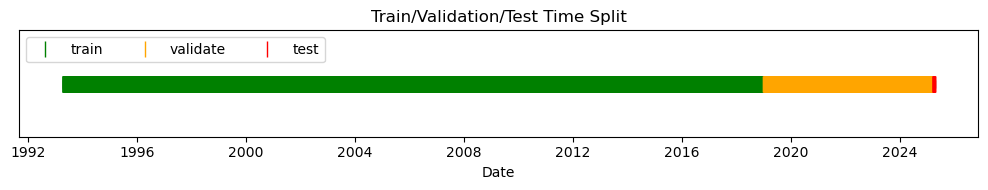

In [43]:
plt.figure(figsize=(10, 2))
plt.plot(df_full['Date'], [1]*len(df_full), '|', color='gray', alpha=0.5)

for label, color in zip(['train', 'validate', 'test'], ['green', 'orange', 'red']):
    subset = df_full[df_full['set'] == label]
    plt.plot(subset['Date'], [1]*len(subset), '|', label=label, color=color, markersize=12)

plt.legend(loc='upper left',ncol=3)
plt.title('Train/Validation/Test Time Split')
plt.yticks([])
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('media/tr_val_ts_distribution')
plt.show()

Save this entire data preparation pipeline and automate process.